# NEURAL NETWORK COLLABORATIVE FILTERING
This notebook demonstrates our approach for NNCF on a small sample dataset.  
Note that some of the functionality is implemented in other classes:
* `twitter_preproc.py` (preprocessing)
* `nnpreprocessor.py` (one hot encoding)
* `NNCFNet.py` (the neural network class)

Our neural network approach for the full dataset is in `nncf-submit.py`. To reproduce our submission attempts use: `spark-submit nncf-submit.py`. (NOTE: As described in our report, this script never actually ran through, due to memory overload exceptions. It is just here for reproduction purposes)

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import importlib

# Building Spark Context
# conf = SparkConf().setAll([('spark.executor.memory', '32g'), ('spark.executor.instances','8'),('spark.executor.cores', '12'), ('spark.driver.memory','64g'), ('spark.driver.memoryOverhead', '64g')])
conf = SparkConf()
spark = SparkSession.builder.appName("nncf_train").config(conf=conf).getOrCreate()
sc = spark.sparkContext

## Get training data

In [2]:
import twitter_preproc

base = "///tmp/"
one_k = "traintweet_1000.tsv"
ensemble_train = 'supersecret_ensembletrain5k_bootstrap.tsv'
ensemble_test = 'supersecret_test5k_bootstrap.tsv'
choice = ensemble_test

preproc = twitter_preproc.twitter_preproc(spark, sc, base+choice, MF=True)
traindata = preproc.getDF()

## NNCF specific preprocessing (essentially onehot-encoding)

In [3]:
import nnpreprocessor
importlib.reload(nnpreprocessor)

nnp = nnpreprocessor.NNPreprocessor()
engagement = 'retweet_comment'
tweets, users, target = nnp.nn_preprocess(traindata)

## Train the NN

In [4]:
from NNCFNet import Net
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd


# Initalize Hyperparameters
k = 64
n_epochs = 2
batch_size = 16
learning_rate = 0.001

# Initialize Neural Network
net = Net(users.shape[1], tweets.shape[1], k)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
output = net(users, tweets)

# printing aids
print_c = 0
loss_list = []

# Start training
for epoch in range(n_epochs):
    
    print("epoch ", epoch+1)

    permutation = torch.randperm(users.size()[0])
    for i in range(0,users.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x_user = users[indices]
        batch_x_tweet = tweets[indices]
        batch_y = target[indices]

        outputs = net.forward(batch_x_user, batch_x_tweet)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        # print & track loss
        loss_list.append((print_c,float(loss)))
        print_c += 1
        
# plot the loss
plot_df = pd.DataFrame(loss_list)
ax = plot_df.set_index(0)[1].plot();
fig = ax.get_figure()

epoch  1
epoch  2


In [5]:
# save loss plot
fig.savefig('../misc/nncf/' + engagement + '.' + 'k' + str(k) + 'ep' + str(n_epochs) + 'batch' + str(batch_size) + str('lr') + str(learning_rate) + '_adam&bce.png')

## Create & format output

In [6]:
from pyspark.sql.functions import monotonically_increasing_id
import numpy as np

# get predictions
net.eval()
prediction = net(users, tweets)
p_vec = prediction.detach().numpy().flatten()

# scale output
scaled = p_vec
# scaled = (p_vec - np.min(p_vec))/np.ptp(p_vec)
probabilities = [float(x) for x in scaled]

# get original order
order_df = traindata.withColumn("original_order", monotonically_increasing_id())
order_df = order_df.select("engaging_user_id", "tweet_id", 'original_order')
sorting_tweets = nnp.get_id_indices(order_df, id_column='tweet_id')

# rejoin labels
result = order_df.join(sorting_tweets, 'tweet_id').sort('original_order').rdd.map(lambda x: (x['engaging_user_id'], x['tweet_id'], probabilities[x['tweet_id_index']]))

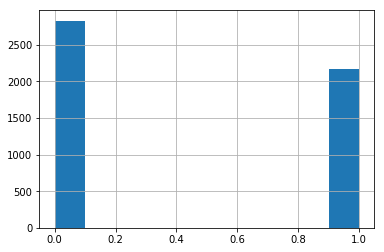

In [7]:
# draw histogram of predictions
hist_df = pd.DataFrame(result.toDF(["engaging_user_id", "tweet_id", 'target']).collect())[2].hist()

In [8]:
result.count()

5000

# EXPORT

In [9]:
output_PATH = str(engagement + '.' + choice).replace('tsv', 'csv')
result_df = result.toDF(["engaging_user_id", "tweet_id", 'target'])
result_df.repartition(1).write.csv(output_PATH, sep="\x01", header=True)